# Home assignment 3. VAE + NF + VAPNEV

In this home assignment I built and trained [Variational Autoencoder (VAE)](https://arxiv.org/abs/1312.6114), [Glow](https://arxiv.org/abs/1807.03039) and the combination of Glow and VAE

### Dataset visualization

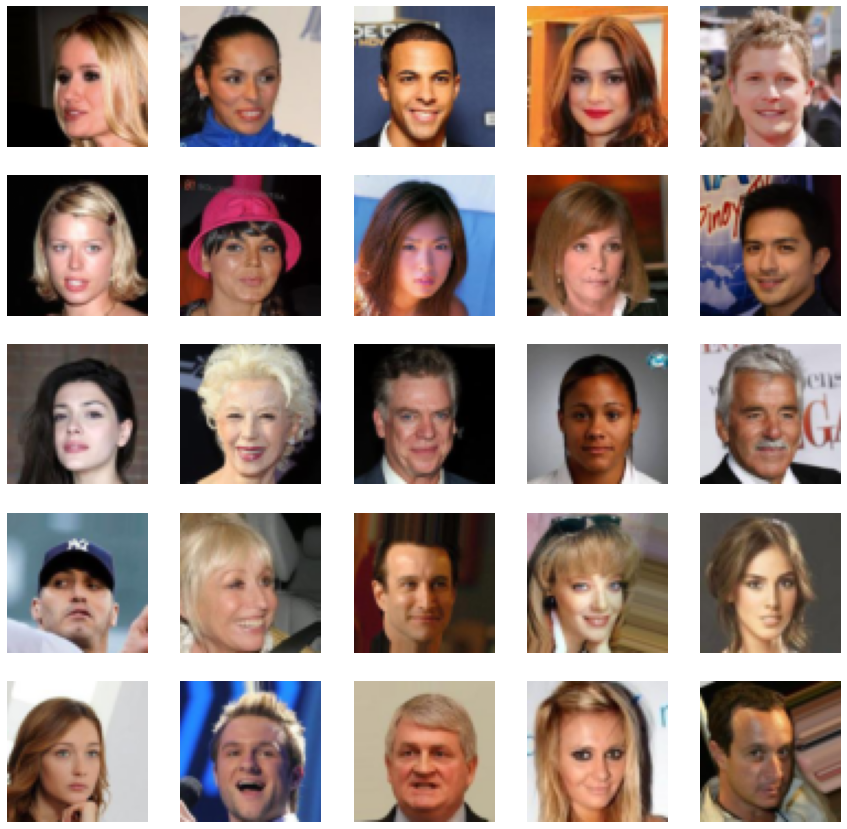

In [6]:
#!g1.1
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

### Glow

#### Evaluation

In [15]:
glow = Glow(3, n_flow, n_block).eval().to(device)
load_checkpoint(glow, "./checkpoints/glow_2.pth", device=device)

repr_rim, repr_gen, z_rim = [], [], []

for i, img in enumerate(test_loader):
    
    img = img.to(device)
    b_size = img.size(0)

    with torch.no_grad():
        repr_rim += inception(img).view(b_size, -1).cpu().numpy().tolist()
        z = glow(img)[-1]
        z_rim += z[-1].view(b_size, -1).cpu().numpy().tolist()
        z_sample = gen_latent(n_block=n_block, b_size=b_size)
        gen_img = glow.reverse(z_sample)
        repr_gen += inception(gen_img).view(b_size, -1).cpu().numpy().tolist()
    
    if i == 20: # 20 * 64 = 1280
        break

repr_rim = np.array(repr_rim)
repr_gen = np.array(repr_gen)
z_rim = np.array(z_rim)

glow_fid = calc_fid(repr_rim, repr_gen)

print(f"Glow FID: {glow_fid:.4f}")

Glow FID: 42.2774


#### Latent analysis

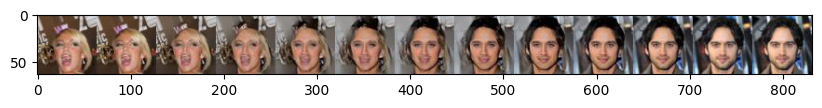

In [95]:
# 1.
import matplotlib.image as mpimg

real_img = next(iter(test_loader))
real_img = real_img.to(device)

img1 = real_img[0].unsqueeze(0)
img2 = real_img[1].unsqueeze(0)

imgs = [img2.cpu()]

with torch.no_grad():
    z_1, z_2 = glow(img1)[-1], glow(img2)[-1]

for i in range(11):
    z = []
    for z1, z2 in zip(z_1, z_2):
        z.append(i / 10 * z1 + (1 - i / 10) * z2)
    with torch.no_grad():
        x_fake = glow.reverse(z, reconstruct=True)
    imgs.append(x_fake.cpu())

imgs.append(img1.cpu())

imgs = torch.cat(imgs, dim=0)
imgs = ((imgs + 1) / 2).clamp_(0, 1)

save_image(imgs.cpu(), './samples/latent_glow.jpg', nrow=13, padding=0)
plt.figure(figsize=(10, 10), dpi=100)
img = mpimg.imread('./samples/latent_glow.jpg')
imgplot = plt.imshow(img)
plt.show()

#### Close embeddings to Leonardo DiCaprio in embedding space

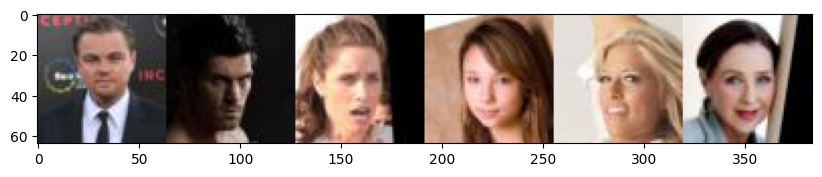

In [17]:
# 2. 
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, metric="cosine")
dicaprio = transform(transforms.Resize((180))(PIL.Image.open("./dicaprio.png").convert('RGB'))).to(device).unsqueeze(0)

knn.fit(z_rim)
with torch.no_grad():
    z_dicaprio = glow(dicaprio)[-1][-1].view(1, -1).cpu().detach().numpy()

idxs = knn.kneighbors(z_dicaprio, 5, return_distance=False)[0]

imgs = [dicaprio.cpu()]
for id in idxs:
    imgs.append(test_dataset[id].unsqueeze(0))

imgs = torch.cat(imgs, dim=0)
imgs = ((imgs + 1) / 2).clamp_(0, 1)

save_image(imgs.cpu(), './samples/neighbour_glow.jpg', ncol=6, padding=0)
plt.figure(figsize=(10, 10), dpi=100)
img = mpimg.imread('./samples/neighbour_glow.jpg')
imgplot = plt.imshow(img)
plt.show()

#### Generated image

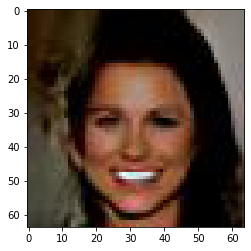

In [18]:
# 3.
z = gen_latent(b_size=1)

with torch.no_grad():
    funny_image = glow.reverse(z).cpu()
    
funny_image = ((funny_image + 1) / 2).clamp_(0, 1)
save_image(funny_image, './samples/funny_glow.jpg', ncol=1, padding=0)
img = mpimg.imread('./samples/funny_glow.jpg')
imgplot = plt.imshow(img)
plt.show()

### VAE

#### Evaluation

In [23]:
vae = VAE().eval().to(device)
load_checkpoint(vae, "./checkpoints/vae_15.pth", device=device)

repr_rim, repr_gen, z_rim = [], [], []

for i, img in enumerate(test_loader):
    
    img = img.to(device)
    b_size = img.size(0)

    with torch.no_grad():
        repr_rim += inception(img).view(b_size, -1).cpu().numpy().tolist()
        z_rim = vae.encode(img).view(b_size, -1).cpu().numpy().tolist()
        gen_img = vae.sample(b_size, device)
        repr_gen += inception(gen_img).view(b_size, -1).cpu().numpy().tolist()
    
    if i == 20: # 20 * 64 = 1280
        break

repr_rim = np.array(repr_rim)
repr_gen = np.array(repr_gen)
z_rim = np.array(z_rim)

vae_fid = calc_fid(repr_rim, repr_gen)

print(f"VAE FID: {vae_fid:.4f}")

VAE FID: 32.7127


#### Latent Analysis

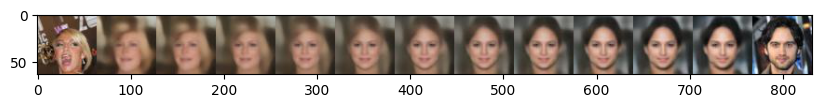

In [97]:
# 1
imgs = [img2.cpu()]

with torch.no_grad():
    z_1, z_2 = vae.encode(img1), vae.encode(img2)

for i in range(11):
    z = i / 10 * z_1 + (1 - i / 10) * z_2
    with torch.no_grad():
        x_fake = vae.decode(z)
    imgs.append(x_fake.cpu())

imgs.append(img1.cpu())

imgs = torch.cat(imgs, dim=0)
imgs = ((imgs + 1) / 2).clamp_(0, 1)

save_image(imgs.cpu(), './samples/latent_vae.jpg', nrow=13, padding=0)
plt.figure(figsize=(10, 10), dpi=100)
img = mpimg.imread('./samples/latent_vae.jpg')
imgplot = plt.imshow(img)
plt.show()

#### Close embeddings to Leonardo DiCaprio in embedding space

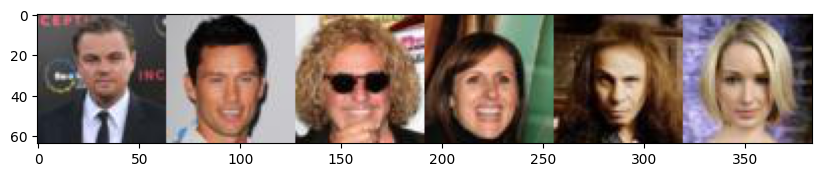

In [26]:
# 2

knn.fit(z_rim)
with torch.no_grad():
    z_dicaprio = vae.encode(dicaprio).view(1, -1).cpu().detach().numpy()

idxs = knn.kneighbors(z_dicaprio, 5, return_distance=False)[0]

imgs = [dicaprio.cpu()]
for id in idxs:
    imgs.append(test_dataset[id].unsqueeze(0))

imgs = torch.cat(imgs, dim=0)
imgs = ((imgs + 1) / 2).clamp_(0, 1)

save_image(imgs.cpu(), './samples/neighbour_vae.jpg', ncol=6, padding=0)
plt.figure(figsize=(10, 10), dpi=100)
img = mpimg.imread('./samples/neighbour_vae.jpg')
imgplot = plt.imshow(img)
plt.show()

#### Generated image

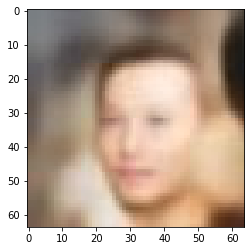

In [28]:
# 3

with torch.no_grad():
    funny_image = vae.sample(1).cpu()

funny_image = ((funny_image + 1) / 2).clamp_(0, 1)
save_image(funny_image, './samples/funny_vae.jpg', ncol=1, padding=0)
img = mpimg.imread('./samples/funny_vae.jpg')
imgplot = plt.imshow(img)
plt.show()

### VAPNEV like model

In this task I had to build the same or similar model to [VAPNEV](https://arxiv.org/pdf/1611.05209.pdf). I decided to build and train [Glow](https://arxiv.org/abs/1807.03039) instead of [Real NVP](https://arxiv.org/abs/1605.08803) in [VAPNEV](https://arxiv.org/pdf/1611.05209.pdf) architecture and kept the same the rest of architecture. 

#### Evaluation

In [43]:
glowv = Glow(3, n_flow, n_block).eval().to(device)
load_checkpoint(glowv, "./checkpoints/glowv_4.pth", device=device)

repr_rim, repr_gen, z_rim = [], [], []

for i, img in enumerate(test_loader):
    
    img = img.to(device)
    b_size = img.size(0)

    with torch.no_grad():
        repr_rim += inception(img).view(b_size, -1).cpu().numpy().tolist()
        mean, logvar, z_v = vae(img)[1:]
        z = glowv(img, mean, logvar, z_v)[-1]
        z_rim += z[-1].view(b_size, -1).cpu().numpy().tolist()
        z_sample = gen_latent(n_block=n_block, b_size=b_size)
        gen_img = glowv.reverse(z_sample, z_v)
        repr_gen += inception(gen_img).view(b_size, -1).cpu().numpy().tolist()
    
    if i == 20: # 20 * 64 = 1280
        break

repr_rim = np.array(repr_rim)
repr_gen = np.array(repr_gen)
z_rim = np.array(z_rim)

glowv_fid = calc_fid(repr_rim, repr_gen)

print(f"Glow VAE FID: {glowv_fid:.4f}")

Glow VAE FID: 30.9512


#### Latent analysis

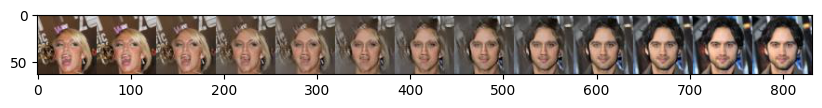

In [99]:
# 1

imgs = [img2.cpu()]
mean1, logvar1, zv_1 = vae(img1)[1:]
mean2, logvar2, zv_2 = vae(img2)[1:]
z_1, z_2 = glowv(img1, mean1, logvar1, zv_1)[-1], glowv(img2, mean2, logvar2, zv_2)[-1]

for i in range(11):
    z = []
    for z1, z2 in zip(z_1, z_2):
        z.append(i / 10 * z1 + (1 - i / 10) * z2)
    zv = i / 10 * zv_1 + (1 - i / 10) * zv_2
    with torch.no_grad():
        x_fake = glowv.reverse(z, zv, reconstruct=True)
    imgs.append(x_fake.cpu())

imgs.append(img1.cpu())

imgs = torch.cat(imgs, dim=0)
imgs = ((imgs + 1) / 2).clamp_(0, 1)

save_image(imgs.cpu(), './samples/latent_glowv.jpg', nrow=13, padding=0)
plt.figure(figsize=(10, 10), dpi=100)
img = mpimg.imread('./samples/latent_glowv.jpg')
imgplot = plt.imshow(img)
plt.show()

#### Close embeddings to Leonardo DiCaprio in embedding space

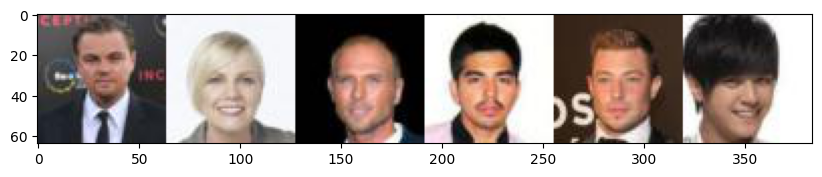

In [75]:
# 2

knn.fit(z_rim)
with torch.no_grad():
    mean, logvar, zv = vae(dicaprio)[1:]
    z_dicaprio = glowv(dicaprio, mean, logvar, zv)[-1][-1].view(1, -1).cpu().detach().numpy()

idxs = knn.kneighbors(z_dicaprio, 5, return_distance=False)[0]

imgs = [dicaprio.cpu()]
for id in idxs:
    imgs.append(test_dataset[id].unsqueeze(0))

imgs = torch.cat(imgs, dim=0)
imgs = ((imgs + 1) / 2).clamp_(0, 1)

save_image(imgs.cpu(), './samples/neighbour_glowv.jpg', ncol=6, padding=0)
plt.figure(figsize=(10, 10), dpi=100)
img = mpimg.imread('./samples/neighbour_glowv.jpg')
imgplot = plt.imshow(img)
plt.show()

#### Generated image

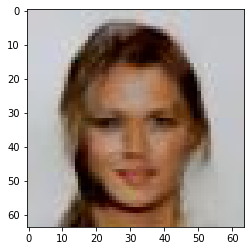

In [76]:
# 3
z = gen_latent(b_size=1, n_block=3, device=device)
noise = torch.randn(1, latent_size).to(device)

with torch.no_grad():
    
    funny_image = glowv.reverse(z, noise).cpu()
    
funny_image = ((funny_image + 1) / 2).clamp_(0, 1)
save_image(funny_image, './samples/funny_glowv.jpg', ncol=1, padding=0)
img = mpimg.imread('./samples/funny_glowv.jpg')
imgplot = plt.imshow(img)
plt.show()